In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import torch
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
df = pd.read_csv("diabetes.csv")

# Let's understand the data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
# print(df.isnull().sum())
print(df.describe())

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

In [5]:
#num of zeros in each column
zero_counts = (df == 0).sum()
print(zero_counts)

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64


Plot histograms of the columns which should't have zeroes


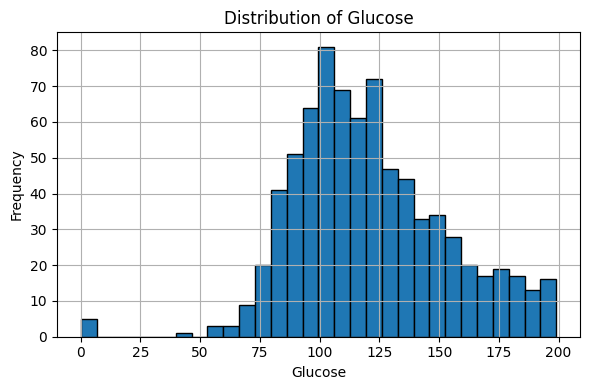

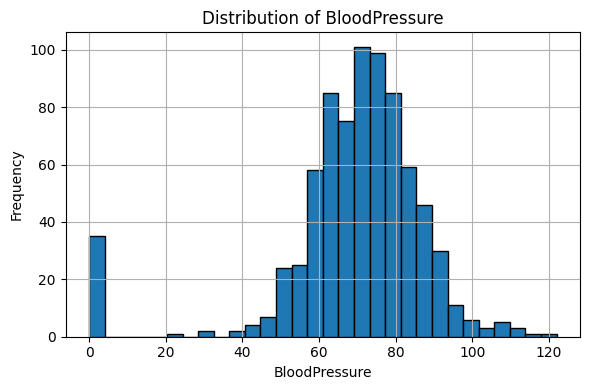

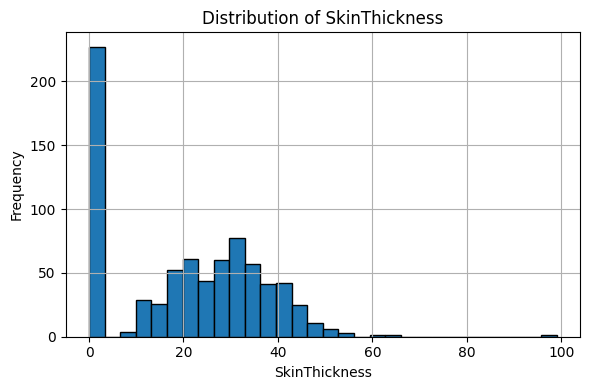

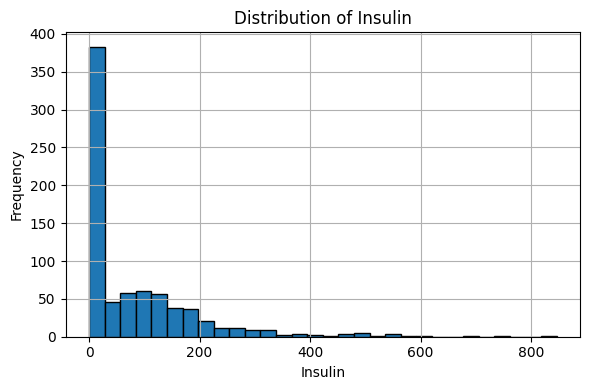

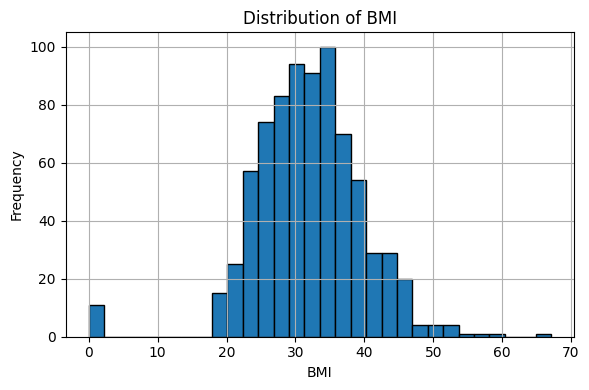

In [6]:
cols_to_check = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for col in cols_to_check:
    plt.figure(figsize=(6, 4))
    plt.hist(df[col], bins=30, edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

- Glucose: Mostly clustered around 100–150, but a small spike at 0.
- BloodPressure: Similar pattern — main distribution around 60–80, with a small group at 0.
- SkinThickness: Highly skewed, many values at 0, and fewer in the normal range (~20–40).
- Insulin: Strongly skewed, many values at 0, with a long tail up to 800+.
- BMI: Normal-ish distribution between 25–40, but a few zeros.

Let's replace zeroes whit the median value:

In [7]:
df[cols_to_check] = df[cols_to_check].replace(0, np.nan)
df[cols_to_check] = df[cols_to_check].fillna(df[cols_to_check].median())

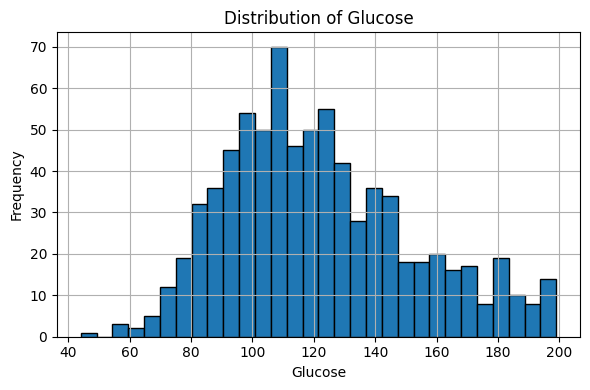

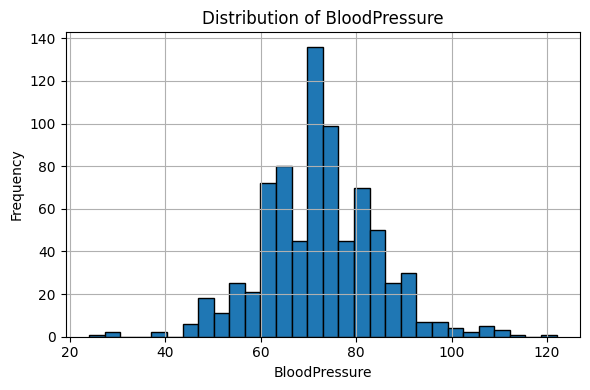

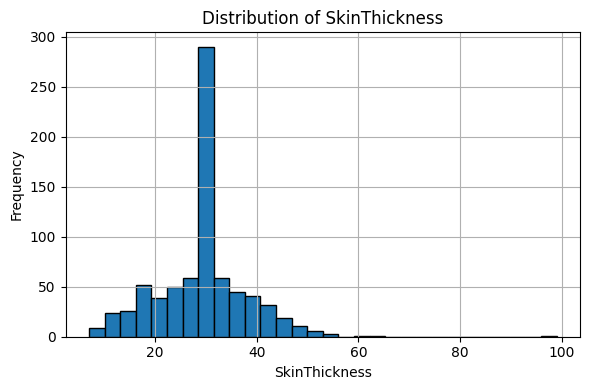

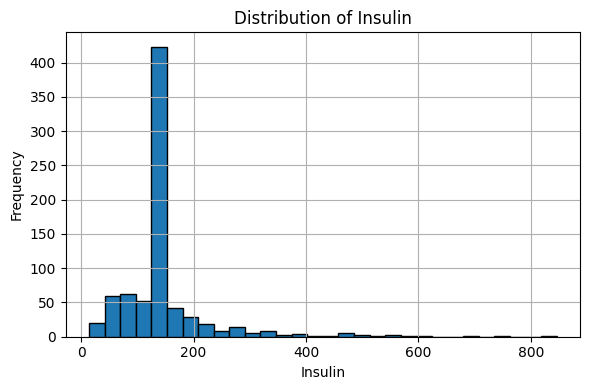

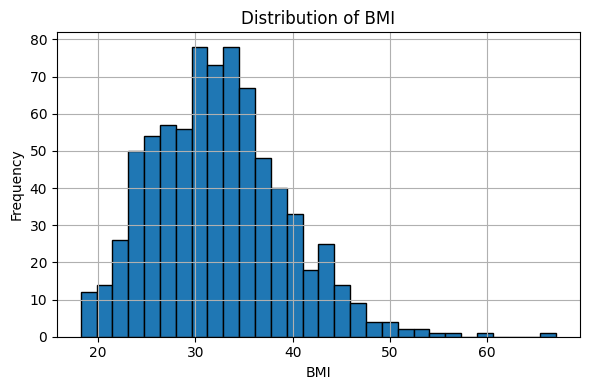

In [8]:
for col in cols_to_check:
    plt.figure(figsize=(6, 4))
    plt.hist(df[col], bins=30, edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [9]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Here we will check the correlation and the effect of each feature:
- Compute correlations
- Visualize them in a heatmap
- Sort feature correlations with respect to the target 

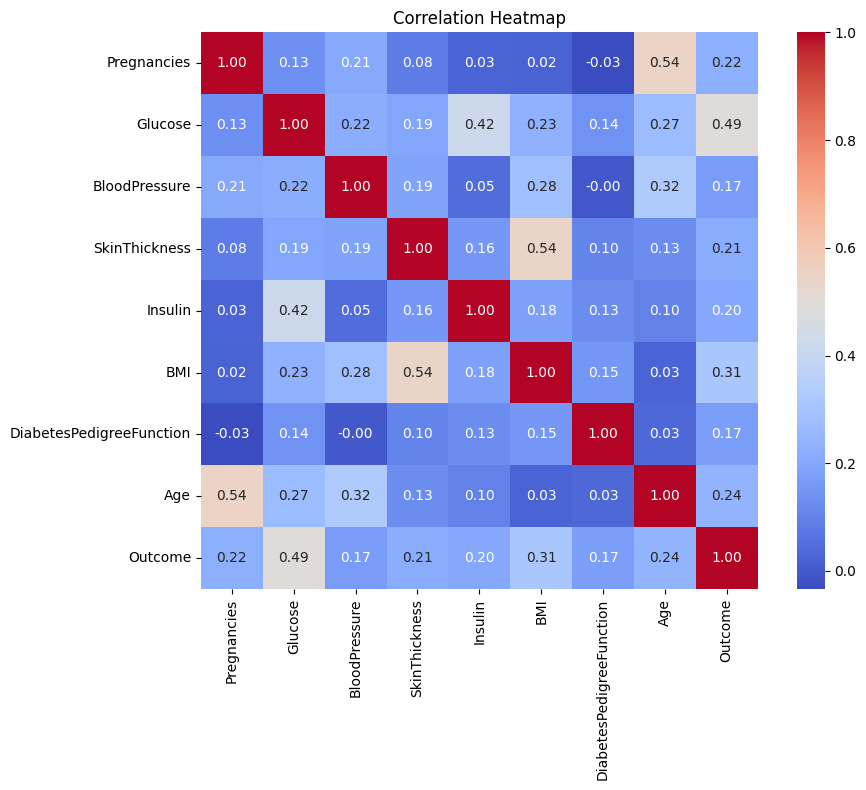

In [10]:
correlation_matrix = df.corr()

# --- Heatmap ---
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

🧠 What the Correlation Shows:
- Glucose is clearly the most important predictor.

There’s some correlation between:
- Pregnancies ↔ Age (older people tend to have more pregnancies)
- BMI ↔ SkinThickness (both are related to body fat)

If two features are highly correlated, one can be dropped to reduce redundancy — especially helpful for models sensitive to multicollinearity (like logistic regression).

Here I'll try the automatic feature selection.

In [11]:
# Apply SelectKBest with ANOVA F-test
selector = SelectKBest(score_func=f_classif, k= 'all')  # you can change k to select top k features
selector.fit(X_scaled, y)

feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector.scores_
}).sort_values(by='Score', ascending=False)

print("Feature scores using SelectKBest (ANOVA F-test):")
print(feature_scores)

Feature scores using SelectKBest (ANOVA F-test):
                    Feature       Score
1                   Glucose  245.667855
5                       BMI   82.629271
7                       Age   46.140611
0               Pregnancies   39.670227
3             SkinThickness   37.078538
4                   Insulin   33.190796
6  DiabetesPedigreeFunction   23.871300
2             BloodPressure   21.631580


As we can see, the top 5 features are: Glucose, BMI, Age, Pregnancies. So, I'll drop less important features and keep these top 5. 

In [12]:
selected_features = df.drop(columns=['Insulin','BloodPressure','DiabetesPedigreeFunction'])

# Separate features and target
X = selected_features.drop('Outcome', axis=1)
y = selected_features['Outcome']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Let's build the data train and test and make the Model prepared:

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [16]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [17]:
y_pred = model.predict(X_test)

In [18]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7012987012987013

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.79      0.77       100
           1       0.58      0.54      0.56        54

    accuracy                           0.70       154
   macro avg       0.67      0.66      0.67       154
weighted avg       0.70      0.70      0.70       154


Confusion Matrix:
 [[79 21]
 [25 29]]


in this step, the accuracy is 70%. It is a solid starting point — especially with just 5 features and a simple model like logistic regression.

Now let’s try to boost performance.

1- trying more powerful model:

In [20]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Try Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


ModuleNotFoundError: No module named 'xgboost'

In [ ]:
! conda install -c conda-forge py-xgboost

Retrieving noticesdone
Channels:
 - conda-forge
Platform: osx-64
doneecting package metadata (repodata.json): - 
doneing environment: \ 

## Package Plan ##

  environment location: /Users/arostamnejadkh/miniforge3

  added / updated specs:
    - py-xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _py-xgboost-mutex-2.0      |            cpu_0           8 KB  conda-forge
    certifi-2025.1.31          |     pyhd8ed1ab_0         159 KB  conda-forge
    conda-24.11.3              |  py312hb401068_0         1.1 MB  conda-forge
    libxgboost-2.1.4           |   cpu_h250267a_1         1.4 MB  conda-forge
    openssl-3.4.1              |       hc426f3f_0         2.5 MB  conda-forge
    py-xgboost-2.1.4           | cpu_pyh1ce2f49_1         133 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         5.3 M

In [ ]:
y
